In [ ]:
from tensorflow.keras import Sequential 
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [ ]:
np.version.version

'1.19.5'

In [ ]:
conda install numpy

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::seaborn-base==0.11.1=pyhd8ed1ab_1
  - conda-forge/noarch::nbclassic==0.2.6=pyhd8ed1ab_0
  - conda-forge/linux-64::numexpr==2.7.2=py36h284efc9_0
  - conda-forge/linux-64::statsmodels==0.12.2=py36h92226af_0
  - conda-forge/linux-64::blaze==0.11.3=py36_0
  - conda-forge/linux-64::matplotlib==3.3.4=py36h5fab9bb_0
  - defaults/linux-64::_anaconda_depends==5.1.0=py36_2
  - conda-forge/linux-64::scipy==1.5.3=py36h9e8f40b_0
  - conda-forge/noarch::jupyterlab==3.0.9=pyhd8ed1ab_0
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/noarch::jupyterlab_server==2.3.0=pyhd8ed1ab_0
  - conda-forge/linux-64::pytables==3.6.1=py36hb7ec5aa_3
  - conda-forge/linux-64::pandas==1.1.5=py36h284efc9_0
  - conda-forge/linux-64::astropy==4.1=py36ha112f06_2
  - conda-forge/noarch::pyls-black==0.4.6=pyh9f0ad1d_

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('s3://cppmsba2/stockproject/QQQ-201901-202104.csv')

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df = df[df['Volume'] != 'N.A.']
df = df.astype({'Volume': 'float64'})
#df['Adjusted Close'] = df['Close']
df = df[['Open','High','Low','Close','Tick Count','Volume']]
split = int(len(df) * 0.8)
print(split)

181299


In [ ]:
x = df[['Open','High','Low','Tick Count','Volume']]
y = df[['Close']]

In [ ]:
X_train_pre = x[:split]
Y_train_pre = y[:split]

In [ ]:
X_test_pre = x[split:]
Y_test_pre = y[split:]

In [ ]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(X_train_pre)
past_60_days = X_train_pre.tail(60)
testdf= past_60_days.append(X_test_pre, ignore_index = True)
test_data = scaler.transform(testdf)
training_data

array([[0.00804351, 0.00943826, 0.00904653, 0.10216025, 0.12559539],
       [0.00973688, 0.011391  , 0.0114546 , 0.09529658, 0.06810545],
       [0.01116973, 0.01191174, 0.01288643, 0.07578932, 0.04172456],
       ...,
       [0.87267162, 0.87163965, 0.87178653, 0.01524456, 0.00854841],
       [0.87104338, 0.87072837, 0.87150016, 0.02124124, 0.01139925],
       [0.87127133, 0.87085856, 0.86976896, 0.02933314, 0.02048404]])

In [ ]:
X_Train = []
Y_Train = []
X_test_pred = []
Y_test_pred = []

In [ ]:
for i in range(60, X_train_pre.shape[0]):
    X_Train.append(training_data[i-60:i])
    Y_Train.append(Y_train_pre[i-1:i])

for i in range(60,test_data.shape[0]):
    X_test_pred.append(test_data[i-60:i])
    Y_test_pred.append(Y_test_pre[i-1:i])

In [ ]:
x_Train_model,y_Train_model = np.array(X_Train), np.array(Y_Train)
X_test_pred = np.array(X_test_pred)

In [ ]:
model = Sequential()
model.add(LSTM(units=50,activation='relu',return_sequences=True,input_shape = (x_Train_model.shape[1],5)))
#model.add(Dropout(0.2))
model.add(LSTM(units=60,activation='relu',return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(units=80,activation='relu',return_sequences=True))
#model.add(Dropout(0.4))
model.add(LSTM(units=120,activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            11200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               96480     
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 179,561
Trainable params: 179,561
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
LSTM_Model = model.fit(x_Train_model, y_Train_model, epochs = 60, batch_size =190, validation_split=0.1)

Train on 163115 samples, validate on 18124 samples
Epoch 1/60
163115/163115 [==============================] - 162s 995us/sample - loss: 6038603639.6427 - val_loss: 489.0781
Epoch 2/60
163115/163115 [==============================] - 148s 909us/sample - loss: 28.7772 - val_loss: 223.3603
Epoch 3/60
163115/163115 [==============================] - 147s 901us/sample - loss: 8.3443 - val_loss: 128.4122
Epoch 4/60
163115/163115 [==============================] - 148s 910us/sample - loss: 4.3303 - val_loss: 20.4510
Epoch 5/60
163115/163115 [==============================] - 148s 909us/sample - loss: 2.6994 - val_loss: 14.4302
Epoch 6/60
163115/163115 [==============================] - 148s 905us/sample - loss: 10288.8930 - val_loss: 80308.6636
Epoch 7/60
163115/163115 [==============================] - 148s 906us/sample - loss: 45599.5670 - val_loss: 80299.2949
Epoch 8/60
163115/163115 [==============================] - 148s 907us/sample - loss: 42424.9726 - val_loss: 80212.7036
Epoch 9/60


In [ ]:
Y_pred = model.predict(X_test_pred)

In [ ]:
Y_test_final = Y_test_pred
Y_pred_final = Y_pred

In [ ]:
testfinaldf=pd.DataFrame(Y_test_final)

In [ ]:
predfinaldf=pd.DataFrame(Y_pred_final)

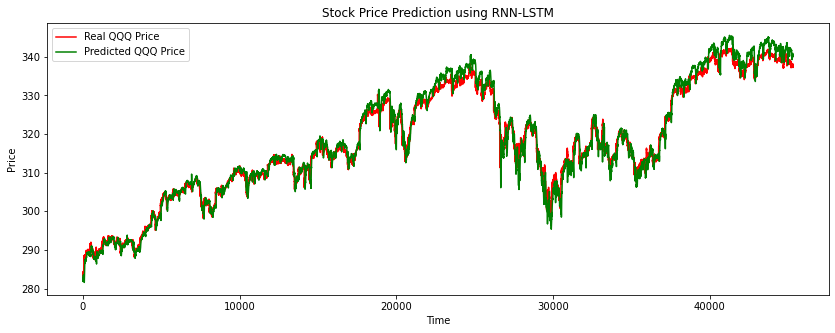

In [ ]:
#60 Epochs 190 Batch_Size
plt.figure(figsize=(14,5))
plt.plot(testfinaldf, color = 'red', label = 'Real QQQ Price')
plt.plot(predfinaldf, color = 'green', label = 'Predicted QQQ Price')
plt.title('Stock Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

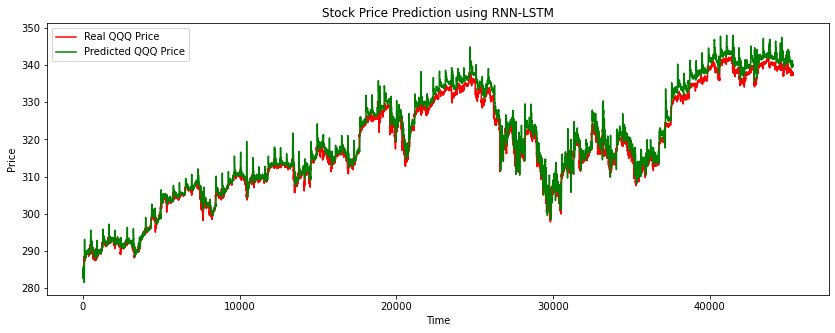

In [ ]:
#20 Epochs 200 Batch_Size
plt.figure(figsize=(14,5))
plt.plot(resetYtest, color = 'red', label = 'Real QQQ Price')
plt.plot(predfinaldf, color = 'green', label = 'Predicted QQQ Price')
plt.title('Stock Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
small_y_test = testfinaldf[:500]
small_y_pred = predfinaldf[:500]

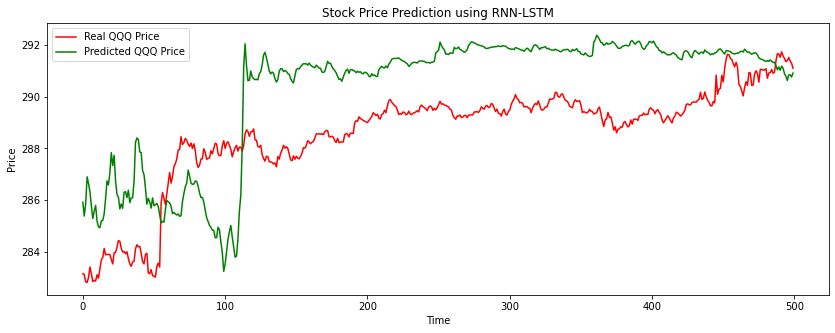

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(small_y_test, color = 'red', label = 'Real QQQ Price')
plt.plot(small_y_pred, color = 'green', label = 'Predicted QQQ Price')
plt.title('Stock Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()